# Requirements

## Install packages

In [1]:
import sys

!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install mlflow
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install hyperopt

## Imports

In [2]:
import mlflow
import time
import sklearn
import numpy as np
import seaborn as sns
import pandas as pd
import getpass
import random
from hyperopt import hp, fmin, tpe, space_eval
import mlflow.pyfunc

# Experiment tracking with ML Flow

MLflow (currently in beta) is an open source platform to manage the ML lifecycle, including experimentation, reproducibility and deployment.

![ML flow](img/introduction-to-mlflow-11-638.jpg)

## Simple example

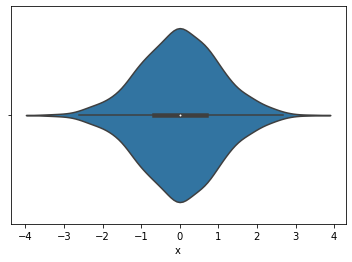

In [3]:
# Create a new experiment or use existing one
mlflow.set_experiment(experiment_name="simple_example")

# Start a ML flow experiment
with mlflow.start_run():
    
    # Log parameters
    mlflow.log_param("Param1", random.randint(0, 10))
    mlflow.log_param("Param2", random.randint(0, 10))
    
    # Log metrics
    mlflow.log_metric("Metric1", random.random())
    mlflow.log_metric("Metric2", random.random())
    
    # Log tag
    mlflow.set_tag("user_name", getpass.getuser())
    
    # Log artifacts
    sns_plot = sns.violinplot(x="x", data=pd.DataFrame(columns=["x"], data=np.random.randn(1000)))
    fig = sns_plot.get_figure() 
    fig.savefig("fig.png")
    mlflow.log_artifact("fig.png")

Experiment can now be accessed with `mlflow ui` command.

## Monitoring

In [4]:
# Create a new experiment or use existing one
mlflow.set_experiment(experiment_name="monitoring")

# Start a ML flow experiment
with mlflow.start_run():
    for _ in range(60):
        time.sleep(0.5)
        mlflow.log_metric("metric", random.random())

## Hyperparameter optimization

In [5]:
# Create a new experiment or use existing one
mlflow.set_experiment(experiment_name="hyperopt")

# Objective function
def objective(case, val):
    return val if case == 'case 1' else val**2 

# Wrap objective function to add mlflow loging
def run_objective(args):
    # Start a nested experiment
    with mlflow.start_run(nested=True) as nested_run:      
        case, val = args
        
        # Add tag
        mlflow.set_tag("objective", "dummy")
        
        # Log params
        mlflow.log_param("case", case)
        mlflow.log_param("val", val)

        metric = objective(case=case, val=val)
        
        # Log metric
        mlflow.log_metric("metric", metric)
        
        return metric
        
# Define search space
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])
        
# Start ml flow run
with mlflow.start_run() as run:   
    best = fmin(run_objective, space, algo=tpe.suggest, max_evals=100)
    
    best_case, best_val = space_eval(space, best)
    best_metric = objective(case=best_case, val=best_val)
    
    # Log params for best run
    mlflow.log_param("case", best_case)
    mlflow.log_param("val", best_val)
    
    # Log result for best run
    mlflow.log_metric("metric", best_metric)

100%|██████████| 100/100 [00:13<00:00,  8.32it/s, best loss: 0.0037797327105731663]


## Model history

The `mlflow_project_model.py` script train a simple model and log it as an artifact. Let's run it.

In [6]:
%%bash 
python mlflow_project_model.py

Starting run da6d4c5fc4aa42af93c92e1ba11a62b1
Using Iris dataset
Training multinomial logistic regression model
Score on test set 0.9736842105263158


/home/k.villatel/.conda/envs/technical_presentations/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


While runing a .py file, mlflow log the commit hash for free. This is convenient to reproduce experiments. Good practice: run from a clean directory! <br>
Logged model contains also all information about dependencies versions.

In [7]:
# Look at the mlflow ui and retrieve trained model id
run_id = "aeb0c1193e964504b1208777294d0d9c"

In [8]:
# Load previously trained model
classifier = mlflow.pyfunc.load_model(model_uri="runs:/{}/model".format(run_id))
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Packaging

In [9]:
%pycat conda.yaml

In [10]:
%pycat MLproject

Run a local project

In [11]:
%%bash
mlflow run . -P max_iter=10

Starting run 8b0e217484a2406bbdfb7a3640066199
Using Iris dataset
Training multinomial logistic regression model
Score on test set 0.9473684210526315


2019/06/11 11:49:19 INFO mlflow.projects: === Created directory /tmp/tmprgkquohe for downloading remote URIs passed to arguments of type 'path' ===
2019/06/11 11:49:19 INFO mlflow.projects: === Running command 'source activate mlflow-d392d4dc1088117298648939bcdcf3fcbd700030 && python mlflow_project_model.py --seed=0 --max_iter=10' in run with ID '8b0e217484a2406bbdfb7a3640066199' === 
/home/k.villatel/.conda/envs/mlflow-d392d4dc1088117298648939bcdcf3fcbd700030/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
2019/06/11 11:49:20 INFO mlflow.projects: === Run (ID '8b0e217484a2406bbdfb7a3640066199') succeeded ===


Run a distant project

In [12]:
%%bash
mlflow run https://github.com/KiewanVillatel/technical_presentations.git

Starting run 373e3cb87d514fba9385377446a878de
Using Iris dataset
Training multinomial logistic regression model
Score on test set 0.9736842105263158


2019/06/11 11:49:22 INFO mlflow.projects: === Fetching project from https://github.com/KiewanVillatel/technical_presentations.git into /tmp/tmpr19hqdro ===
2019/06/11 11:49:24 INFO mlflow.projects: === Created directory /tmp/tmplhaiezml for downloading remote URIs passed to arguments of type 'path' ===
2019/06/11 11:49:24 INFO mlflow.projects: === Running command 'source activate mlflow-d392d4dc1088117298648939bcdcf3fcbd700030 && python mlflow_project_model.py --seed=0 --max_iter=100' in run with ID '373e3cb87d514fba9385377446a878de' === 
/home/k.villatel/.conda/envs/mlflow-d392d4dc1088117298648939bcdcf3fcbd700030/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
2019/06/11 11:49:25 INFO mlflow.projects: === Run (ID '373e3cb87d514fba9385377446a878de') succeeded ===


In [13]:
%%bash
mlflow run https://github.com/KiewanVillatel/technical_presentations.git -v 3655ae

Starting run 9b27a0aa31754657a1c92713fbe66918


2019/06/11 11:49:27 INFO mlflow.projects: === Fetching project from https://github.com/KiewanVillatel/technical_presentations.git into /tmp/tmp1npapwhs ===
2019/06/11 11:49:29 INFO mlflow.projects: === Created directory /tmp/tmpdvrtdliv for downloading remote URIs passed to arguments of type 'path' ===
2019/06/11 11:49:29 INFO mlflow.projects: === Running command 'source activate mlflow-d392d4dc1088117298648939bcdcf3fcbd700030 && python mlflow_project_model.py --seed=0' in run with ID '9b27a0aa31754657a1c92713fbe66918' === 
/home/k.villatel/.conda/envs/mlflow-d392d4dc1088117298648939bcdcf3fcbd700030/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
2019/06/11 11:49:30 INFO mlflow.projects: === Run (ID '9b27a0aa31754657a1c92713fbe66918') succeeded ===


Going further: https://mlflow.org/